In [42]:
import os
import sys
import joblib

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd 
import numpy as np 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities import utils
DATA_PATH = utils.get_datapath('data')
SPOTIFY_DATA = utils.get_datapath('spotify_scrape')


**Table of contents**<a id='toc0_'></a>    
- [**5. Extracting Data From Spotify**](#toc1_)    
- [Querying the API for Popularity](#toc2_)    
- [Distribution of Spotify Popularity](#toc3_)    
- [Extracting Genre](#toc4_)    
- [Dealing With Genres](#toc5_)    
  - [Mapping Tracks to Genre](#toc5_1_)    
- [Combining the Scraped Data, Ada Embeddings and Original Dataset](#toc6_)    
  - [Dealing With Duplicated Titles](#toc6_1_)    
- [Splitting the Popularity Into Multi-Class](#toc7_)    
- [Conclusion](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[**5. Extracting Data From Spotify**](#toc0_)

The preliminary modeling demonstrated that we could not go beyond approximately 10% accuracy increase over the baseline when using the Genius.com page views. We decided to look at another proxy of popularity. Specifically, we wanted to scrape the Spotify popularity for each track, as well as the genre. 

The Spotify popularity is a number that ranges from 0 (unpopular) to 100 (popular). This value is influenced by many factors, but the major factors are the total plays and how recently the song has been played. We believed that this may be a better proxy for evaluating a songs popularity. The genre information could also provide further data to evaluate the relationships between lyrics and popularity. Namely, we wanted to see if lyrics could predict popularity better depending on the genre. 

The first step to extract the data from Spotify was to initialize our connection with the API. 

In [40]:
# Stores the API keys used to access info from spotify. 
# Save your keys in API-key.txt with client_id and client_secret on their own lines.
with open(DATA_PATH/ 'spotify-API-key-2.txt') as f:
    API_keys = {
        key_type: key_value.replace('\n', '')
        for key_type, key_value in zip(['client_id', 'client_secret'], f.readlines())
    }
    
       

In [41]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=API_keys['client_id'],
                                                           client_secret=API_keys['client_secret']))

# <a id='toc2_'></a>[Querying the API for Popularity](#toc0_)

Now that we have initialized the connection we can query each track by its track name and get its popularity. 

In [42]:
def get_spotify_popularity(track_name):
    '''
        This function extracts the spotify popularity for each track in the dataset. 
        This index is affected by:
            - Total Streams of a Song
            - How recently a song has been played.
            - The frequency that a track has been played.
        The index ranges from a score of 0 (not relevant at all) to 100 (Most popular tracks).
    '''
    # This returns a dictionary for a search request through the spotify API
    track = sp.search(q=track_name, type='track', limit=1)
    # Access Spotify's popularity.
    popularity = track['tracks']['items'][0]['popularity']
    
    return popularity

In [69]:
df = pd.read_csv(DATA_PATH / 'clean_lyrics_english.csv')

In [71]:
df.head()

,Unnamed: 0,song,lyrics,title,primary_artist,views,cleaned_lyrics,language,log_scaled_views,popular,popularity,popularity_std
0,0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,Swimming Pools (Drank),Kendrick-lamar,5589280.0,pour up drank head shot drank sit down drank ...,en,15.536361,1,2,2
1,1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,Money Trees,Kendrick-lamar,4592003.0,uh me and my niggas tryna get it ya bish ya b...,en,15.339827,1,2,2
2,2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",XXX.,Kendrick-lamar,4651514.0,america god bless you if its good to you amer...,en,15.352703,1,2,2
3,3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",Fuckin’ Problems,A-ap-rocky,7378309.0,i love bad bitches thats my fuckin problem an...,en,15.814055,1,2,2
4,4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",DNA.,Kendrick-lamar,5113687.0,i got i got i got i got loyalty got royalty i...,en,15.447431,1,2,2


In [45]:
from tqdm import tqdm
import time
spotify_popularity = []

Here the API stopped taking requests at multiple intervals, so we had to restart the loop at the song where the API requests were limited. 

We found that adding a 200 ms pause between requests provided enough slowdown to stay below the Spotify API rate limit. 

In [46]:

for track in tqdm(df['title'][14530:]):
    # This is to stay under the API request rate limit. 
    for i in range(50):
        try:
            time.sleep(0.200)
            spotify_popularity.append(get_spotify_popularity(track))
            break
        except IndexError as i:
            print(i)
            spotify_popularity.append(np.nan)
            break
        except Exception as e:
            print(e)
            continue
        
    


  9%|▉         | 1968/21408 [11:02<1:52:16,  2.89it/s]

list index out of range


 11%|█▏        | 2456/21408 [13:47<1:49:59,  2.87it/s]

list index out of range


 12%|█▏        | 2575/21408 [14:26<1:58:36,  2.65it/s]

list index out of range


 18%|█▊        | 3833/21408 [21:24<1:41:24,  2.89it/s]

list index out of range


 20%|█▉        | 4278/21408 [23:54<1:28:36,  3.22it/s]

list index out of range


 36%|███▌      | 7626/21408 [42:41<1:18:40,  2.92it/s]

list index out of range


 39%|███▉      | 8345/21408 [46:41<1:18:15,  2.78it/s]

list index out of range


 45%|████▍     | 9611/21408 [53:55<1:17:39,  2.53it/s]

list index out of range


 45%|████▍     | 9613/21408 [53:56<1:19:27,  2.47it/s]

list index out of range


 48%|████▊     | 10351/21408 [58:00<1:02:12,  2.96it/s]

list index out of range


 48%|████▊     | 10362/21408 [58:03<55:50,  3.30it/s]  

('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))


 55%|█████▌    | 11859/21408 [1:06:25<56:29,  2.82it/s]  

list index out of range


 61%|██████    | 13060/21408 [1:13:04<49:17,  2.82it/s]  

list index out of range


 73%|███████▎  | 15562/21408 [1:26:52<31:29,  3.09it/s]  

list index out of range


 93%|█████████▎| 19919/21408 [1:50:52<07:37,  3.25it/s]

'NoneType' object is not subscriptable


 97%|█████████▋| 20671/21408 [1:55:05<04:44,  2.59it/s]

list index out of range


 98%|█████████▊| 21035/21408 [1:57:04<01:57,  3.16it/s]

('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))


 99%|█████████▉| 21283/21408 [1:58:25<00:50,  2.48it/s]

list index out of range


100%|█████████▉| 21377/21408 [1:58:56<00:10,  3.05it/s]

list index out of range


100%|██████████| 21408/21408 [1:59:07<00:00,  3.00it/s]


In [47]:
len(spotify_popularity)

21408

The spotify popularity scrape had to be broken up into two parts as the rate limit in the API created an error that interrupted the scrape. So the scrape was dump once before rerunning the scrape above. If there were no errors in you do not need to run the following cells.

In [ ]:

with open(SPOTIFY_DATA/ 'spotify_popularity_2.pkl', 'wb') as file:
    joblib.dump(spotify_popularity, file)
    

In [43]:
with open(SPOTIFY_DATA/ 'spotify_popularity.pkl', 'rb') as file:
    spotify_popularity_first_batch = joblib.load(file)

In [45]:
with open(SPOTIFY_DATA/ 'spotify_popularity_2.pkl', 'rb') as file:
    spotify_popularity_second_batch = joblib.load(file)

In [47]:
total_spotify_popularity = spotify_popularity_first_batch + spotify_popularity_second_batch

In [48]:
len(total_spotify_popularity)

35938

In [72]:
df['spotify_popularity'] = total_spotify_popularity

In [73]:
spotify_df = df.dropna(axis = 0).reset_index(drop=True)

In [74]:
spotify_df['spotify_popularity'].shape

(35908,)

# <a id='toc3_'></a>[Distribution of Spotify Popularity](#toc0_)

After extracting all the Spotify popularity values we decided to look at the distributions of the Spotify popularity. As we can see from the plot below the Spotify popularity looks to be normally distributed, unlike the Genius.com views. 

<AxesSubplot:ylabel='Frequency'>

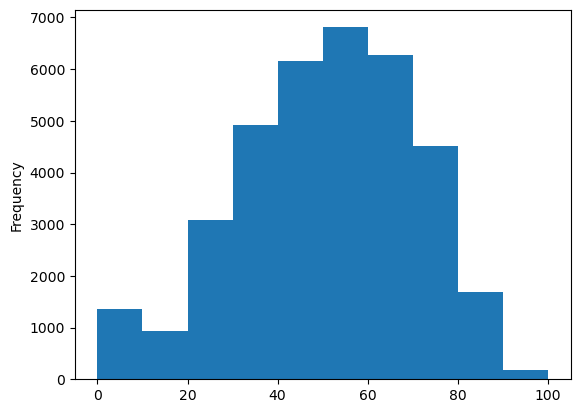

In [75]:
spotify_df['spotify_popularity'].plot(kind='hist')

In [ ]:
spotify_df.to_csv(DATA_PATH / 'clean_lyrics_spotify_popularity.csv', index=False)

# <a id='toc4_'></a>[Extracting Genre](#toc0_)

The Spotify API stores only genre for the artists and not the individual tracks themselves. The best we can do is to take the artists in the dataset and map the genres for each of the artists and use that as the genre for each track.

In [93]:
# Get unique artists in the dataset this limits the amount of API necessary.
unique_artists = spotify_df['primary_artist'].unique()


In [95]:
def get_artist_genre(artist_name):
    artist = sp.search(q=artist_name, type='artist', limit=1)
    genre = artist['artists']['items'][0]['genres']
    return genre

In [100]:
# Spotify only provides genre that an artist is related to not individual tracks
# Will create a mapping of artist name to genres and use this to label the genre of every track.
artist_genre_mapping = {}


This loop deals with the extraction of genres for each artist and stores it in a dictionary. The keys for this dictionary are the artists and the values are the genre lists, as Spotify returns multiple genres per artist. 

In [101]:

for artist in tqdm(unique_artists):
    for i in range(50):
        try:
            time.sleep(0.2)
            if artist not in artist_genre_mapping:
                artist_genre_mapping[artist] = get_artist_genre(artist)
            break
        except IndexError as i:
            print(i)
            artist_genre_mapping[artist] = [(np.nan)]
            break
        except Exception as e:
            print(e)
            continue



  2%|▏         | 68/3136 [00:18<15:37,  3.27it/s]

list index out of range


 39%|███▉      | 1223/3136 [06:11<11:19,  2.82it/s]

list index out of range


 41%|████      | 1272/3136 [06:26<09:41,  3.21it/s]

list index out of range


 41%|████      | 1280/3136 [06:29<09:18,  3.32it/s]

list index out of range


 63%|██████▎   | 1987/3136 [10:06<05:39,  3.39it/s]

list index out of range


 69%|██████▉   | 2167/3136 [11:02<04:58,  3.24it/s]

('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))


 83%|████████▎ | 2609/3136 [13:18<02:41,  3.26it/s]

list index out of range


100%|██████████| 3136/3136 [16:00<00:00,  3.26it/s]


In [105]:
for artist in artist_genre_mapping:
    if np.nan in artist_genre_mapping[artist]:
        print(artist)

The-weeknd-and-kendrick-lamar
Billie-eilish-and-justin-bieber
Ed-sheeran-and-beyonce
Ed-sheeran-chris-stapleton-and-bruno-mars
Drake-kanye-west-lil-wayne-and-eminem
Sex-love-and-vices


Some of these mappings had no genre from the API and since there were a minimial number we entered the genres by hand. 

In [108]:
artist_genre_mapping['The-weeknd-and-kendrick-lamar'] = ['hip hop']

In [111]:
artist_genre_mapping['Billie-eilish-and-justin-bieber'] = ['pop']

In [112]:
artist_genre_mapping['Ed-sheeran-and-beyonce'] = ['pop']

In [113]:
artist_genre_mapping['Ed-sheeran-chris-stapleton-and-bruno-mars'] = ['rock']

In [114]:
artist_genre_mapping['Drake-kanye-west-lil-wayne-and-eminem'] = ['rap']

In [116]:
artist_genre_mapping['Sex-love-and-vices'] = ['hip hop']

After getting the artist to genre mapping we dumped this file for use later.

In [117]:
with open(DATA_PATH/ 'artist_genre_mapping.pkl', 'wb') as file:
    joblib.dump(artist_genre_mapping, file)

# <a id='toc5_'></a>[Dealing With Genres](#toc0_)

To deal with the multiple genres for each artist we decided to take the most common main archetype of genre and assign only one of those genres to the artist. There are many disadvantages to this method, but the main advantage is the speed. 

To perform this reduction in genres, we need to first make a counter of every genre split into its component parts. 

For example `underground rap` would be split into `underground` and `rap`. We hoped that this would elucidate the most common main genres. 

In [11]:
from collections import Counter


In [12]:
with open(SPOTIFY_DATA / 'artist_genre_mapping.pkl', 'rb') as file:
    artist_genre_mapping = joblib.load(file)

In [13]:
all_genres = []

for detailed_genres in artist_genre_mapping.values():
    all_genres = all_genres + detailed_genres
    

In [14]:
# Split each individual detailed genres into 
# separate wordsand see what are the most common overall genres are

all_detailed_genres = []

for genre in all_genres:
    all_detailed_genres = all_detailed_genres + genre.split(' ')

In [15]:
# Count the split genres. 
genre_counter = Counter(all_detailed_genres)

In [16]:
#Get the top archetypes of genres. 
top_genres = [
    'hip hop' if top_genre[0] in ['hip', 'hop'] else top_genre[0]
    for top_genre in genre_counter.most_common()[:9]
]

# Remove the duplicate of hip hop.
top_genres.pop(0)
top_genres

['hip hop', 'rap', 'pop', 'trap', 'dance', 'r&b', 'southern', 'rock']

We can see from the above that the most common main genres were `hip hop`, `rap`, `pop`, `trap`, `dance`, `r&b`, `southern` and `rock`. 

## <a id='toc5_1_'></a>[Mapping Tracks to Genre](#toc0_)

Now that we have the 8 most common main genres we mapped the main genre to the artist. If the artist has none of the main genres, we decided to just set the value to `other` for simplicity sake. 

In [17]:
# Generate a mapping with the artist and single genre. 
for artist in artist_genre_mapping:
    artist_genre = artist_genre_mapping[artist]
    
    # If there is no genre from the spotify API. 
    if not artist_genre:
        artist_genre_mapping[artist] = 'other'

    for subgenre in artist_genre:
        if ('hip hop' or 'rap') in subgenre:
            artist_genre_mapping[artist] = 'hip hop'
            break
        elif 'pop' in subgenre:
            artist_genre_mapping[artist] = 'pop'
            break
        elif 'trap' in subgenre:
            artist_genre_mapping[artist] = 'trap'
            break
        elif 'dance' in subgenre:
            artist_genre_mapping[artist] = 'dance'
            break
        elif 'r&b' in subgenre:
            artist_genre_mapping[artist] = 'r&b'
            break
        elif 'southern' in subgenre:
            artist_genre_mapping[artist] = 'southern'
            break
        elif 'rock' in subgenre:
            artist_genre_mapping[artist] = 'rock'
            break
        else:
            artist_genre_mapping[artist] = 'other'
            break


    

Now that we have a one to one mapping between the artist and one genre we can map the genres to each individual track.

In [18]:
# This function maps the genre to the track based on the artist.
def map_genre(artist, artist_single_genre_mapping):
    genre = artist_single_genre_mapping[artist]
    return genre

In [21]:
DATA_PATH = utils.get_datapath('data')
df = pd.read_csv(DATA_PATH / 'clean_lyrics_and_spotify.csv')

In [22]:
from tqdm import tqdm
tqdm.pandas()

In [23]:
df['genre'] = df['primary_artist'].progress_apply(lambda x: map_genre(x, artist_genre_mapping))

100%|██████████| 35908/35908 [00:00<00:00, 1922996.27it/s]


In [24]:
df['genre'].isna().mean()

0.0

In [25]:
df.shape

(35908, 15)

In [26]:
df.columns

Index(['Unnamed: 0', 'song', 'lyrics', 'title', 'primary_artist', 'views',
       'cleaned_lyrics', 'language', 'log_scaled_views', 'popular',
       'popularity', 'popularity_std', 'spotify_popularity',
       'spotify_popularity_three_class', 'genre'],
      dtype='object')

In [27]:
df.to_csv(DATA_PATH / 'clean_lyrics_and_spotify.csv', index=False)

We have successfully mapped the genres in an effective way to the tracks. 

# <a id='toc6_'></a>[Combining the Scraped Data, Ada Embeddings and Original Dataset](#toc0_)

We will now combine the original dataset with the Spotify data and the Ada embeddings. 

In [57]:
original = pd.read_csv(DATA_PATH/'clean_lyrics_english_stem.csv')

In [30]:
spotify = pd.read_csv(DATA_PATH / 'clean_lyrics_and_spotify.csv')

In [58]:
ada = pd.read_csv(DATA_PATH / 'clean_lyrics_ada.csv')

In [38]:
spotify.columns

Index(['Unnamed: 0', 'song', 'lyrics', 'title', 'primary_artist', 'views',
       'cleaned_lyrics', 'language', 'log_scaled_views', 'popular',
       'popularity', 'popularity_std', 'spotify_popularity',
       'spotify_popularity_three_class', 'genre'],
      dtype='object')

## <a id='toc6_1_'></a>[Dealing With Duplicated Titles](#toc0_)

One oversight that we didn't take into account were the amount of duplicate song titles by different artists. These songs would have the same lyrics, but the popularity may be different depending on which artist covered the song. With this in mind, we decided to just take the first occurence of a song in the dataset for simplicity sake. 

In [59]:
# Choose the columns that we want to add to the original dataset.
reduced_spotify = spotify[['title', 'spotify_popularity', 'genre']]
reduced_ada = ada[['title', 'ada_embeddings']]

In [72]:
# Find the unique titles in each dataset.
spotify_titles = set(reduced_spotify['title'])
original_titles = set(original['title'])
ada_titles = set(reduced_ada['title'])
print(len(spotify_titles))
print(len(original_titles))
print(len(ada_titles))

30222
28585
30216


Here we can see that there are more unique titles in the Ada embeddings dataset. This is due to the fact that the dataset was embedded by using all lyrics regardless if it was missing release year, but the original dataset included only lyrics with release years. 

We now need to create a mask to remove the duplicated titles for both the genres dataframe and the original dataframe.

In [73]:
# Create a mask that keeps the first occurence of a title.
unique_titles_spotify_reduced_mask = ~reduced_spotify.duplicated(subset='title', keep='first')
# Subset the dataset using the map to only show unique titles.
unique_titles_spotify_reduced_df = reduced_spotify[unique_titles_spotify_reduced_mask]

In [74]:
# Perform the same masking and subset process to the ada embeddings.
unique_titles_ada_mask = ~reduced_ada.duplicated(subset='title', keep='first')
unique_titles_ada_df = reduced_ada[unique_titles_ada_mask]

In [75]:
common_spotify_ada_titles = ada_titles.intersection(spotify_titles)

In [76]:
# Subset the spotify data to match the ada data. 
unique_titles_spotify_reduced_df = unique_titles_spotify_reduced_df[
    unique_titles_spotify_reduced_df['title'].isin(common_spotify_ada_titles)
]

Now the spotify and ada datasets are the same size and contain unique song titles. We can now merge them.

In [79]:
combined_spotify_ada_df = pd.merge(
    unique_titles_spotify_reduced_df,
    unique_titles_ada_df,
    on='title',
)

In [84]:
display(combined_spotify_ada_df.columns)
display(combined_spotify_ada_df.shape)

Index(['title', 'spotify_popularity', 'genre', 'ada_embeddings'], dtype='object')

(30216, 4)

We have successfully merged both the Ada embeddings and Spotify data.

We will now make a mask of the original dataset to subset the unique titles for the original data.

In [83]:
# Perform the same masking and subset process to the original dataframe.
unique_titles_original_mask = ~original.duplicated(subset='title', keep='first')
unique_titles_original_df = original[unique_titles_original_mask]

In [85]:
common_titles = common_spotify_ada_titles.intersection(original_titles)

In [86]:
len(common_titles)

28560

We can now subset the Ada + Spotify dataframe with unique titles that are common in the original dataframe.

In [87]:
# Subsetting the reduced dataframe to the titles that are similar to the original dataframe.
combined_spotify_ada_df = combined_spotify_ada_df[
    combined_spotify_ada_df['title'].isin(common_titles)
]

In [88]:
# Check the dimensions to make sure the subset was performed correctly.
combined_spotify_ada_df.shape

(28560, 4)

Now we can merge the two dataframes.

In [89]:
final_df = pd.merge(
    unique_titles_original_df,
    combined_spotify_ada_df,
    on='title',
)

In [90]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28560 entries, 0 to 28559
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   song                    28560 non-null  object 
 1   lyrics                  28560 non-null  object 
 2   release_year            28560 non-null  int64  
 3   title                   28560 non-null  object 
 4   primary_artist          28560 non-null  object 
 5   views                   28560 non-null  float64
 6   cleaned_lyrics          28560 non-null  object 
 7   language                28560 non-null  object 
 8   log_scaled_views        28560 non-null  float64
 9   popular                 28560 non-null  int64  
 10  popularity_three_class  28560 non-null  int64  
 11  cleaned_lyrics_stem     28560 non-null  object 
 12  spotify_popularity      28560 non-null  float64
 13  genre                   28560 non-null  object 
 14  ada_embeddings          28560 non-null

In [91]:
final_df.shape
final_df.to_csv(DATA_PATH / 'clean_lyrics_final.csv', index=False)

# <a id='toc7_'></a>[Splitting the Popularity Into Multi-Class](#toc0_)

We will now divide the Spotify popularity into thirds (low, medium and high popularity).

In [92]:
df = pd.read_csv(DATA_PATH / 'clean_lyrics_final.csv')

In [96]:
# Perform split popularity into thirds.
df['spotify_popularity_three_class'] = pd.cut(
    df['spotify_popularity'], 
    bins = [
        0,
        df['spotify_popularity'].quantile(q=0.33), 
        df['spotify_popularity'].quantile(q=0.66),
        df['spotify_popularity'].max()
    ],
    labels=[0,1,2],
    include_lowest=True
    )

In [99]:
df['spotify_popularity_three_class'].value_counts(normalize=True)

1    0.338901
0    0.337920
2    0.323179
Name: spotify_popularity_three_class, dtype: float64

We have successfully rencoded Spotify popularity into 3 balanced classes for modeling. 

In [100]:
df.to_csv(DATA_PATH / 'clean_lyrics_final.csv', index=False)

: 

# <a id='toc8_'></a>[Conclusion](#toc0_)
After our preliminary modeling (`notebooks/3_prelim_modelling.ipynb`), we found that we could not push model performance with the current dataset. From the above we have successfully extracted and combined Spotify data onto our current dataset along with the ada embeddings. 

We can now move onto to refining our models with this finalized dataset. 